# Loan Approval Prediction, a classification problem

### How accurate will we be predicting determinations for loan approval requests?

In [ ]:
# Dataset location - https://www.kaggle.com/shaijudatascience/loan-prediction-practice-av-competition

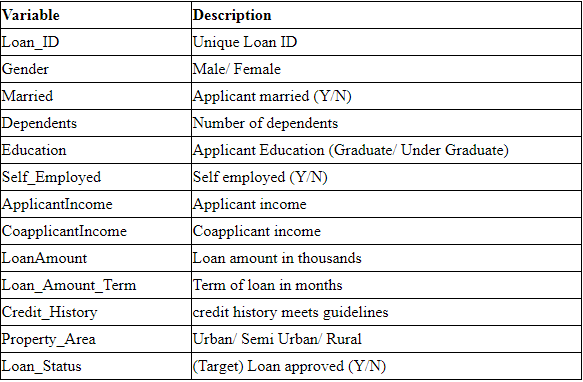

In [5]:
from IPython.display import Image

Image(filename='../images/loan_variables.png')

In [ ]:
# There are 13 variables in the dataset.
# 'Loan_Status' is our target; we are attempting to predict loan approvals.
# To address any potential for data leakage, we will refrain from creating 
# any new features using the target, we won't perform any fitting using our 
# validation sets, and we will watch for any significant declines in our 
# models' performance when scoring our validation sets. 

# Notebook Index

- `Part I, Imports & EDA`
 
- `Part II, Wrangle Data`
    `-`
    `(wrangle_I, wrangle_II, wrangle_II)`
- `Part III, Split the Data`
    
- `Part IV, Establish a Baseline`

- `Part V, Build Models`
    `-`
    `(LogisticRegression(), RandomForestClassifier())` 

- `Part VI, Check Metrics`

- `Part VII, Tune Models & Recheck Metrics`

# I. Imports & EDA 

In [7]:
# Import packages and package classes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [176]:
# It's a small dataset, but > the threshold of 500 observations.

train = pd.read_csv('../data/class-project/LoanApproval/train_data.csv')

print(train.shape)
train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [177]:
# The target vector is 'Loan_Status'

# The classes of the Target Vector are moderately imbalanced towards approval, but < 70%, we 
# can still look at model accuracy for scoring. 
# You have a 68.73% chance of being correct if you always decide that the loan was approved.

train['Loan_Status'].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

In [9]:
# There are a lot of categorical variables; there are NaN values in the dataset. 

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [11]:
# Examine the number of unique entries for variables.

for col in list(train.columns):
    print(col, train[col].nunique())

Loan_ID 614
Gender 2
Married 2
Dependents 4
Education 2
Self_Employed 2
ApplicantIncome 505
CoapplicantIncome 287
LoanAmount 203
Loan_Amount_Term 10
Credit_History 2
Property_Area 3
Loan_Status 2


In [12]:
# Examine 'Dependents' feature

print(train['Dependents'].unique())

['0' '1' '2' '3+' nan]


In [100]:
# Examine 'Property_Area' feature
# No missing values, implies either all loans are home/property purchases, or is
# indicating where loan applicant resides. 

print(train['Property_Area'].value_counts())

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


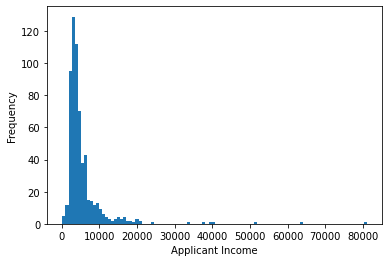

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  income_adj  
count      564.000000  614.000000  
mean         0.842199   54.034593  
std          0.364878   61.090417  
min          0.000000    1.500000  
25%          1.000000   28.775000  
50%          1.000000   38.125000  
75%          1.000000   57.950000  
max          1.000000  810.000000  


In [199]:
# Complete histogram plots of the continuous variables,
# and explore their distributions.

# Applicant Income
train['ApplicantIncome'].plot(kind='hist', bins=100)

plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.show();

print(train.describe())

# Possible outliers present.
# Also 'Applicant_Income' and 'Coapplicant_Income' may need to be addressed (scaled).  
# Information from dataset authorindicates 'LoanAmount' is in thousands.  This would 
# mean the min amount requested was $9,000, and the max loan request was $700,000.
# If the same scale is used for 'ApplicantIncome' it would indicate a low of
# $150,000, and a high of $81 million - a highly unlikely spread.  It would also
# imply a max 'CoapplicantIncome' of > $41 million!

In [186]:
train['income_adj'] = train['ApplicantIncome'] / 100

train['income_adj'].describe()

count    614.000000
mean      54.034593
std       61.090417
min        1.500000
25%       28.775000
50%       38.125000
75%       57.950000
max      810.000000
Name: income_adj, dtype: float64

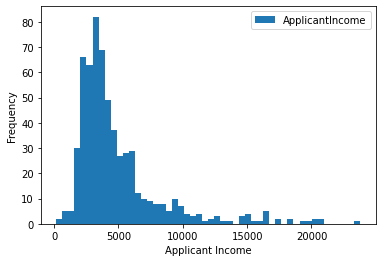

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       605.000000         605.000000  583.000000        591.000000   
mean       4906.877686        1512.712264  143.317324        342.741117   
std        3472.102471        2064.711468   78.533250         64.541662   
min         150.000000           0.000000    9.000000         12.000000   
25%        2876.000000           0.000000  100.000000        360.000000   
50%        3775.000000        1213.000000  127.000000        360.000000   
75%        5708.000000        2283.000000  165.000000        360.000000   
max       23803.000000       20000.000000  650.000000        480.000000   

       Credit_History  
count      556.000000  
mean         0.843525  
std          0.363632  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  


In [91]:
# Explore removing outliers from 'ApplicantIncome' and 'CoapplicantIncome' are > $250,000.

explore = train[ (train['ApplicantIncome'] < 25_000) &
                 (train['CoapplicantIncome'] < 25_000)]

explore[['ApplicantIncome']].plot(kind='hist', bins=50)
plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.show();

print(explore.describe())

# Loss of 9 observations.

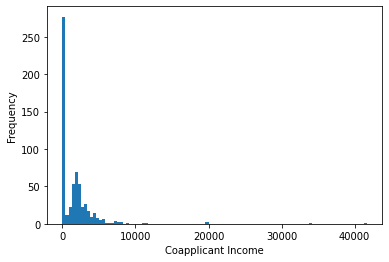

In [94]:
# Coapplicant Income

train['CoapplicantIncome'].plot(kind='hist', bins=100)

plt.xlabel('Coapplicant Income')
plt.ylabel('Frequency')
plt.show();

# Appears to have potential outliers on the high end of income.
# Zero income is not out-of-the-ordinary; there are many single income households.

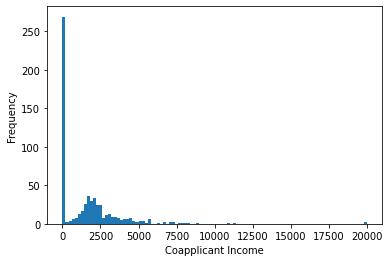

In [95]:
# Coapplicant Income, explore

explore['CoapplicantIncome'].plot(kind='hist', bins=100)

plt.xlabel('Coapplicant Income')
plt.ylabel('Frequency')
plt.show();

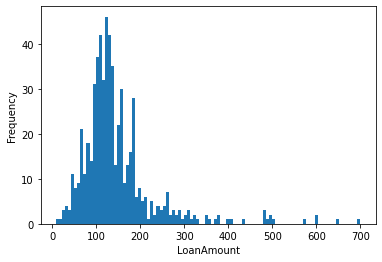

In [96]:
# Loan Amount

train['LoanAmount'].plot(kind='hist', bins=100)

plt.xlabel('LoanAmount')
plt.ylabel('Frequency')
plt.show();

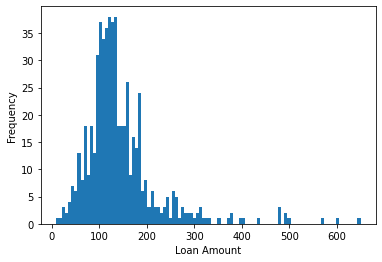

In [97]:
# Loan Amount, explore

explore['LoanAmount'].plot(kind='hist', bins=100)

plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show();

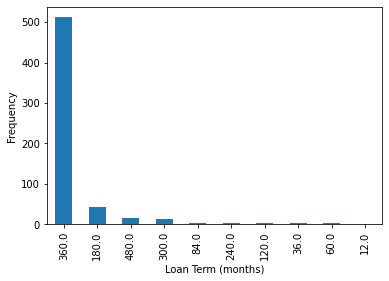

In [99]:
# Examine 'Loan_Amount_Term', listed as a float, really a categorical variable, 10 categories.

train['Loan_Amount_Term'].value_counts().plot(kind='bar')

plt.xlabel('Loan Term (months)')
plt.ylabel('Frequency')
plt.show();

# Primarily 30-year notes, likely mortgages. terms of 12-months might indicate a personal loan, 
# 3-year and 5-year durations are more typical with auto-lending.  What's odd, however, is that 
# every observation (all 614) have an input value for 'Property_Area' (urban, semi-urban, rural).
# Further clarification of the data would have been preferred. 

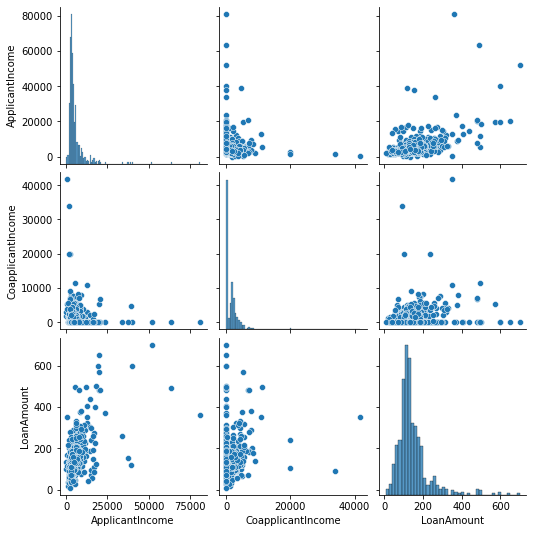

In [103]:
# Examine for correlation among continuous variables; possible outliers noted.

sns.pairplot(train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])
plt.show()

## Summary of Initial EDA

In [ ]:
# 'Loan_ID', high cardinality column, variable is a unique identifier and will be dropped.
# 'Gender', binary categorical variable, assignment == Male/Female, NaN objects hold no meaning.
# 'Married', binary categorical feature, assignment == Y/N, NaN objects hold no meaning.
# 'Dependents', categorical feature, assignment == 0/1/2/3+, NaN objects hold no meaning.
# 'Education', binary categorical feature, assignement == Graduate/Not Graduate, no NaN objects.
# 'Self-Employed', binary categorical feature, assignment = Y/N, NaN objects hold no meaning.
# 'ApplicantIncome', continuous numeric feature, possible outliers, NaN values without meaning.
# 'CoapplicantIncome', continuous numeric feature, possible outliers, NaN values without meaning.
# 'LoanAmount', continuous numeric feature, possible outliers, NaN values without meaning.
# 'Loan_Amount_Term', categorical variable, cardinality == 10, NaN values without meaning.
# 'Credit_History', binary categorical variable, assignment == 1/0, NaN values without meaning. 
# 'Proprty_Area', categorical variable, cardinality == 3, no NaN values. 

# II. Wrangle Data

In [472]:
# Write wrangle function

def wrangle(filepath):

    # Read in the data
    df = pd.read_csv('../data/class-project/LoanApproval/' + filepath)
    
    # Drop high-cardinality identifier column, 'Loan_ID'
    df.drop(columns='Loan_ID', inplace=True)
    
    # Cleanup column names
    df.columns = [col.lower() for col in df.columns]       
    df = df.rename(columns=
        {'applicantincome': 'applicant_income',
         'coapplicantincome': 'coapplicant_income',
         'loanamount': 'loan_amount'})
    
    # Fill NaN values with the mode of the feature it resides in ('most_frequent'); exception, 'loan_amount'
    mode_cols = ['gender', 'married', 'dependents', 'self_employed', 'loan_amount_term', 'credit_history']
    for col in mode_cols:
        df[col].fillna(value=df[col].mode()[0], inplace=True)
    
    # Drop remaining NaN values, all in 'loan_amount' column; difficult to predict without this information. 
    df.dropna(inplace=True)
    
    # Scale 'applicant_income' and 'coapplicant_income' to thousands
    df['applicant_income'] = df['applicant_income'] / 100
    df['coapplicant_income'] = df['coapplicant_income'] / 100
       
    # Convert 'credit_history' to binary categorical from float 
    df['credit_history'].replace(to_replace={1.0: '1', 0.0: '0'}, 
                                 inplace=True)
    
    # Convert 'loan_amount_term' to categorical variable (object) from float
    df['loan_amount_term'] = df['loan_amount_term'].astype(int).astype(str) 

    # Clean 'dependents' feature
    df['dependents'] = df['dependents'].str.strip('+')

    # Convert target, 'LoanStatus' to binary numeric values
    df['loan_status'].replace(to_replace={'Y': 1, 'N':0}, inplace=True) 
  
    # Creat 'loan_to_income' feature
    df['loan_to_income'] = df['loan_amount'] / (df['applicant_income'] + df['coapplicant_income'])

    return df

train_path = 'train_data.csv'
train= wrangle(train_path)

In [473]:
print(train.shape)
train.head()

(592, 13)


,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status,loan_to_income
1,Male,Yes,1,Graduate,No,45.83,15.08,128.0,360,1,Rural,0,2.101461
2,Male,Yes,0,Graduate,Yes,30.00,0.00,66.0,360,1,Urban,1,2.200000
3,Male,Yes,0,Not Graduate,No,25.83,23.58,120.0,360,1,Urban,1,2.428658
4,Male,No,0,Graduate,No,60.00,0.00,141.0,360,1,Urban,1,2.350000
5,Male,Yes,2,Graduate,Yes,54.17,41.96,267.0,360,1,Urban,1,2.777489


In [474]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592 entries, 1 to 613
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              592 non-null    object 
 1   married             592 non-null    object 
 2   dependents          592 non-null    object 
 3   education           592 non-null    object 
 4   self_employed       592 non-null    object 
 5   applicant_income    592 non-null    float64
 6   coapplicant_income  592 non-null    float64
 7   loan_amount         592 non-null    float64
 8   loan_amount_term    592 non-null    object 
 9   credit_history      592 non-null    object 
 10  property_area       592 non-null    object 
 11  loan_status         592 non-null    int64  
 12  loan_to_income      592 non-null    float64
dtypes: float64(4), int64(1), object(8)
memory usage: 64.8+ KB


In [476]:
train.describe()

,applicant_income,coapplicant_income,loan_amount,loan_status,loan_to_income
count,592.000000,592.000000,592.000000,592.000000,592.000000
mean,54.043041,16.426333,146.412162,0.694257,2.375569
std,61.640730,29.677175,85.587325,0.461111,0.829519
min,1.500000,0.000000,9.000000,0.000000,0.252292
25%,28.872500,0.000000,100.000000,0.000000,1.931344
50%,38.060000,12.210000,128.000000,1.000000,2.413912
75%,57.545000,23.120000,168.000000,1.000000,2.814862
max,810.000000,416.670000,700.000000,1.000000,8.271164


# III. Split the Data

In [477]:
# Create Feature Matrix and Target Array

target = 'loan_status'

y = train[target]
X = train.drop(columns=target)

In [478]:
# Split the data
# Will use a random split; there is no datetime information included in this dataset.

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# IV. Establish a Baseline

In [479]:
# The target vector is 'Loan_Status'
# The classes of the TV are moderately imbalanced towards approval, but < 70%, so we can still look at 
# model accuracy for scoring. 

# You have a 69.43% chance of being correct if you always decide that the loan was approved.
print('Baseline Accuracy for predicting Loan Approval: {:.2f}%'.format
      (y.value_counts(normalize=True).max()*100))


Baseline Accuracy for predicting Loan Approval: 69.43%


# V. Build Models

- `LogisticRegression`
    
    - `OneHotEncoder`
    - `StandardScaler`
 
- `RandomForrestClassifier`

    - `OrdinalEncoder`

In [481]:
# Model 1: Logistic Regression Model

model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

/Users/frankhowd/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-YelssOLa/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [482]:
# Model 2: Random Forest Classifier Model

model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_jobs=-1, random_state=42)
)

model_rf.fit(X_train, y_train);

# VI. Check Metrics

In [486]:
# Training and Validation accuracy of our Logistic Regression model

print('Training Accuracy (LOGR): {:.2f}%'.format(model_lr.score(X_train, y_train)*100))
print('Validation Accuracy (LOGR): {:.2f}%'.format(model_lr.score(X_val, y_val)*100))

Training Accuracy (LOGR): 82.45%
Validation Accuracy (LOGR): 78.99%


In [490]:
# Cross Validation Score for our Logistic Regression model

lr_cvs = cross_val_score(model_lr, X_train, y_train, cv=5, n_jobs=-1)

print('Cross Validation Score (LOGR):')
for _ in range(5):
    print(lr_cvs[_])

Cross Validation Score (LOGR):
0.8210526315789474
0.8210526315789474
0.8
0.7978723404255319
0.8085106382978723


In [484]:
# Training and Validation accuracy of our Random Forest Classifier model

print('Training Accuracy(RF): {:.2f}%'.format(model_rf.score(X_train, y_train)*100))
print('Validation Accuracy (RF): {:.2f}%'.format(model_rf.score(X_val, y_val)*100))

wrangle_I, Training Accuracy(RF): 100.00%
wrangle_I, Validation Accuracy (RF): 78.99%


In [491]:
# Cross Validation Score for our Random Forest Classifier model

rf_cvs = cross_val_score(model_rf, X_train, y_train, cv=5, n_jobs=-1)

print('Cross Validation Score (LOGR):')
for _ in range(5):
    print(rf_cvs[_])

Cross Validation Score (LOGR):
0.8526315789473684
0.8105263157894737
0.7684210526315789
0.851063829787234
0.8191489361702128


In [485]:
# Initial performances appear the same on average, howefer, the RF Classifier achieves higher scores
# during cross validation testing. 